# OKCupid Age

Back in 2014, I was 26 and I set out to search the OKCupic population within an empirically determined range of ages (24-33) that seemed similar to me.
Individuals outside of this range are interested in parts of life that did not match my state of life.
Quantifying this is an interesting question:  
  * Can one infer the age of a profile given how well it matches others?
  * Can one estimate the age of a profile given numbers in the username?

In [33]:
%matplotlib inline
import time
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

from pysurvey.plot import setup_sns as setup
from pysurvey.plot import density, icolorbar, text, legend, outline

In [135]:
people = pd.read_csv('/Users/ajmendez/data/okcupid/random_v4.csv')
people = people[(people['age'].notnull()) & (people['match'].notnull()) & (people['match'] > 20)]
print('Found {:,d} profiles'.format(len(people)))

Found 310,434 profiles


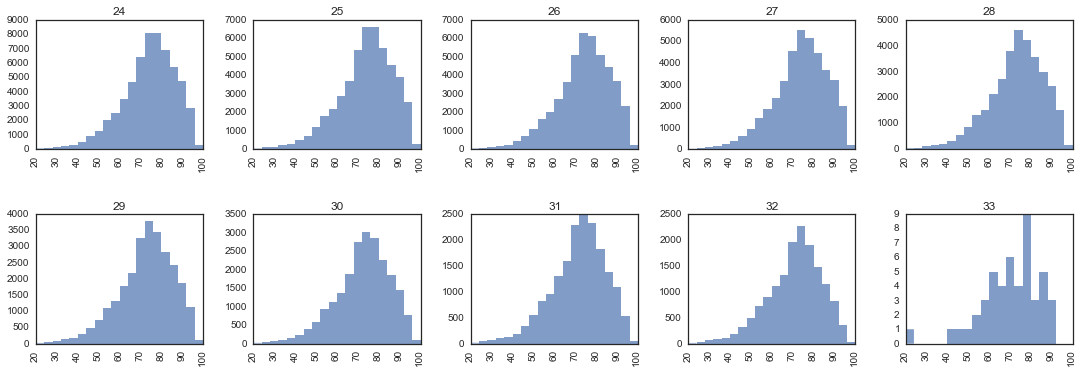

In [26]:
_ = people.hist('match', by='age', bins=np.arange(20,101,4), 
                lw=0, alpha=0.7, figsize=(18,6), layout=(2,5))

From the match percentage distribution grouped by age, I find that there is an underlying distribution that we are sampling that peaks around a mean value near ~75%. What is of interest to answer this question is what differences relative to a mean distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12213f150>]], dtype=object)

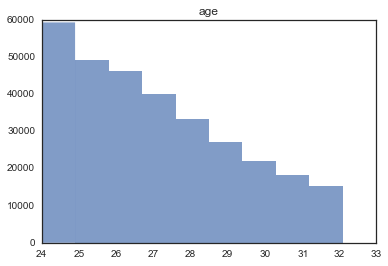

In [27]:
people.hist('age', lw=0, alpha=0.7, grid=False)

Additionally, there is a decreasing number of users at a given age that are presented in the search results.

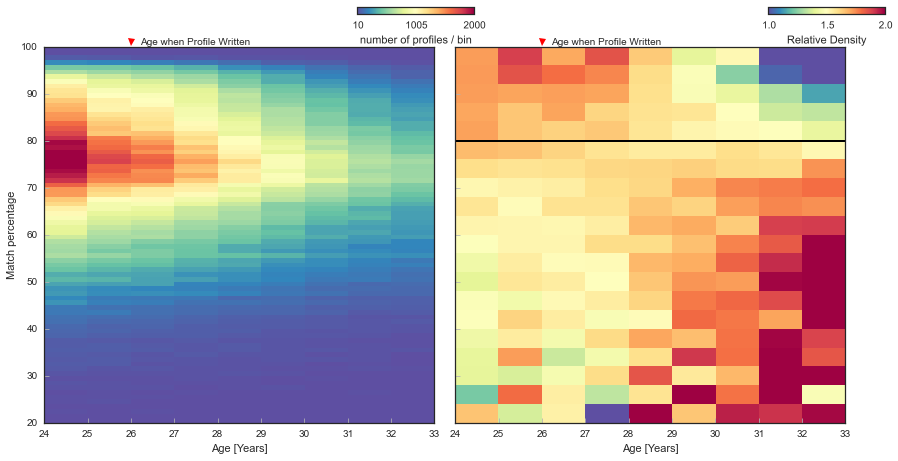

In [28]:
def setup_plot(**kwargs):
    setup(xlabel='Age [Years]', ylabel='Match percentage', tickmarks=False, grid=False, **kwargs)
    pylab.plot(26, 101, 'v', color='r', markeredgecolor='k', clip_on=False)
    pylab.text(26.2, 100, 'Age when Profile Written', ha='left', va='bottom', clip_on=False)

setup_plot(figsize=(12,6), subplt=(1,2,1))
den = density(people['age'], people['match'], 
              bins=[np.arange(24,34), np.arange(20,101,1)],
              label='number of profiles / bin', vmin=10, vmax=2000,
              cmap=pylab.cm.Spectral_r, colorbar=False, logvrange=False)
icolorbar(den, loc=1, borderpad=-4)

setup_plot(subplt=(1,2,2), yticks=False)
den = density(people['age'], people['match'], 
              bins=[np.arange(24,34), np.arange(20,101,4)],
              label='Relative Density',
              vmin=2e-6, vmax=4e-6,
              cmap=pylab.cm.Spectral_r, colorbar=False,
              ynorm=True, xnorm=True, logvrange=False)
pylab.axhline(80, lw=2, color='k')
# convert binning size and probability distribution values to a simple number
icolorbar(den, loc=1, borderpad=-4, tickfmt='{:0.1f}', tickfcn=lambda x: x*0.5e6)

pylab.tight_layout()

To show this effect visually, I show the the 2D age and match percentage distribution in the left panel.
Redder bins highlight the region where we find many more profiles.
This is weighted by the number of observed profiles at a given age, and the match percentage probability distribution, peaking at both low age (24) and a match percentage near 75%.

In the right panel, I normalize the previous panel by the age and match percentage distributions, allowing us to see the relative excess density of profiles that match mine. 

Effectively this suggests that while I may see many more high match percentage profiles for 24 year olds, due is just due to the underlying sample of people who have signed up to OKCupid, my profiles matches people similar to my age
In particular, for the high match (>80%) profiles, my profile is more likely to attact similar ages 25-28 rather than older ages (30+). 

One possible issue with this dataset is that OKCupid may be filtering individuals based on their preferences.
So the dirth of high match percentage profiles above 30 years old may just be people who would not want to date a 26 year old. This [OKTrends blog post](http://blog.okcupid.com/index.php/the-case-for-an-older-woman/) may suggest that this is not a significant problem as that the distribution of preferences extends past 24 years old.

It would be great to extend this dataset by collecting a much larger range of ages to sample the full probability distribution to see what my age my profile matches best against. 
Additionally, it would be useful to add the comparison of many other profiles to calculate the varaince of matching a profile to an age.

# Usernames

* Another interesting feature to consider in the dataset is the number that is included in each username.  These are used to add uniquness to a user's favorite username which has already been selected.  Lets look at how well these values correlate with the age and see if we can estimate their age or profile creation date using these values. 
* Lets first focus on users who have supplied a 2 digit number in their username

In [29]:
num = people[(people['username_nlength'] == 2)]
print('Found {:,d} users with a 2 digit number'.format(len(num)))

Found 64,233 users with a 2 digit number


Found 8,334 12.97%
Found 14,836 23.10%
Found 21,381 33.29%


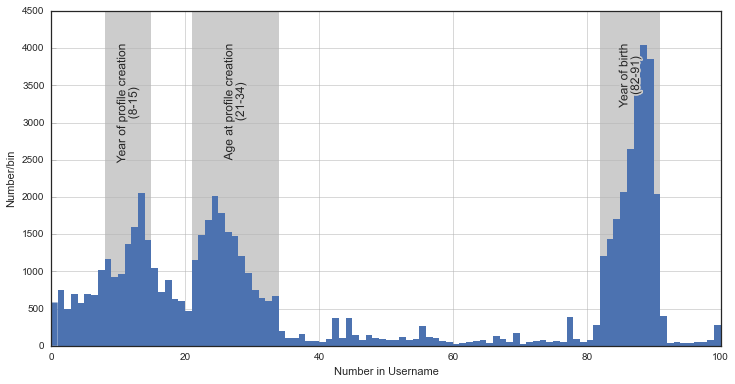

In [41]:
def add_range(xr, label):
    yr = pylab.ylim()
    n = len(np.where((num['username_number'] > xr[0]) & (num['username_number'] < xr[1]))[0])
    print('Found {:,d} {:0.2f}%'.format(n, n*100.0/len(num))) 
    pylab.axvspan(xr[0],xr[1], lw=0, alpha=0.2, zorder=-1, color='k')
    text(np.mean(xr), yr[-1]*0.9, label+'\n({:d}-{:d})'.format(*xr), ha='center', va='top', rotation=90, fontsize=12,
         outline_prop=dict(color='0.8'))

ax=setup(figsize=(12,6), xlabel='Number in Username', tickmarks=False, grid=True, ylabel='Number/bin')
num.hist('username_number', bins=np.arange(0,101), lw=0, ax=ax)
pylab.title('')
add_range([8, 15], 'Year of profile creation')
add_range([21,34], 'Age at profile creation')
add_range([82,91], 'Year of birth')

You can clearly see three peaks which I suggest correspond to three schemas:

* 08 - 15: Two digit year in which the profile was probably created
* 21 - 34: Age of the individual at the time of profile creation
* 80 - 91: Two digit year of their birth

The first schema should not correlate with age -- there should be a somewhat similar influx of users into each okcupid each year.  The other two should correlate with the age of the profile.

In [44]:
age

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

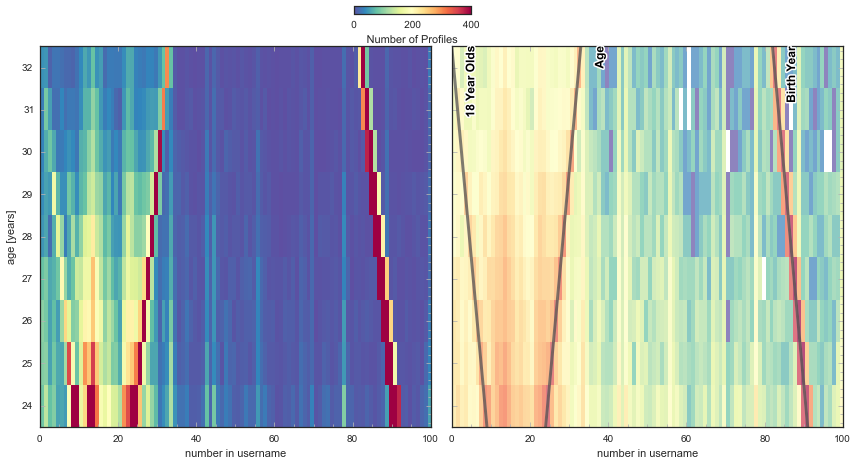

In [82]:
def setup_plot(**kwargs):
    setup(xlabel='number in username', ylabel='age [years]', 
          ytickv=age+0.5, yticknames=age, **kwargs)
def add_line(x,y, label, **kwargs):
    params = dict(label=label, lw=3, alpha=0.5, color='k')
    params.update(kwargs)
    outline(pylab.plot(x,y, **params))
    text(x[-1]+5, y[-1], label, rotation=90, ha='center', va='top', 
         fontsize=12, fontweight='bold', color=params['color'])
    
setup_plot(figsize=(12,6), subplt=(1,2,1))
den = density(num['username_number'], num['age'], 
              bins=[np.arange(0,101), np.arange(24,34), ],
              label='Number of Profiles', vmin=0, vmax=400,
              ynorm=False, cmap=pylab.cm.Spectral_r, colorbar=False)
icolorbar(den, loc=1, borderpad=-4)


setup_plot(subplt=(1,2,2), xr=[0,100], yticks=False)
den = density(num['username_number'], num['age'], alpha=0.7,
              bins=[np.arange(0,101), np.arange(24,34), ], logvrange=True,
              label='Number of Profiles', #vmin=0, vmax=1000,
              cmap=pylab.cm.Spectral_r, colorbar=False)
age = np.arange(24,34)
add_line(115-age, age, 'Birth Year')
add_line(age, age, 'Age')
add_line(33-age, age, '18 Year Olds')
pylab.tight_layout()

In [314]:
zip(age, 33-age, 115-age)

[(24, 9, 91),
 (25, 8, 90),
 (26, 7, 89),
 (27, 6, 88),
 (28, 5, 87),
 (29, 4, 86),
 (30, 3, 85),
 (31, 2, 84),
 (32, 1, 83),
 (33, 0, 82)]

Clearly, two digit numbers in usernames show interesting structure which can be used to infer the age.
The birth year trend (82-91) is the strongest, the age (24-33) follows closely, and the lowest signal strength is in the profile creation year (8-15).

One can see in this plot that the 08-15 range is the combination of two populations, one that does not vary with age, and one that scales with the birth year.  The first being the year of the profile creation which does not correlate with the age of the profile.  The second population in the 08-15 range is harder to model analytically.
I posit that it is the age at which the user has turned 18. For example for a 24 year old in 2015, they turned 18 in 2009.  Likewise a 33 year old would have turned 18 in 2000.

It would be worth investigating if these users who are using the year of their 18th birthday are bots or just users who became of age and use the same username for all of their profiles.

# Correlation with Match Percentage

* Before I dig into using machine learning to estimate the age from the values, lets investigate if there are any trends with match percentage

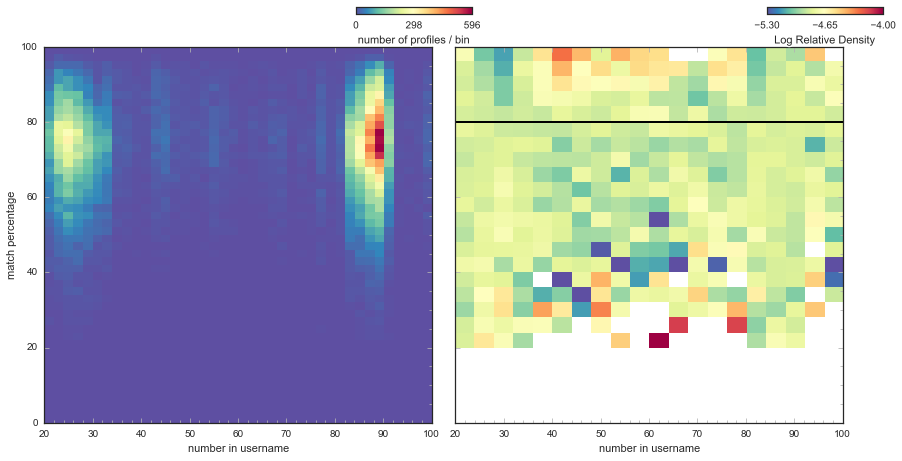

In [59]:
def setup_plot(**kwargs):
    setup(xlabel='number in username', ylabel='match percentage', **kwargs)

setup_plot(figsize=(12,6), subplt=(1,2,1))
den = density(num['username_number'], num['match'], 
              bins=[np.arange(20,101,2), np.arange(0,101,2)],
              label='number of profiles / bin',
              cmap=pylab.cm.Spectral_r, colorbar=False, logvrange=False)
icolorbar(den, loc=1, borderpad=-4)

setup_plot(subplt=(1,2,2), yticks=False)
den = density(num['username_number'], num['match'], 
              bins=[np.arange(20,101,4), np.arange(0,101,4)],
              label='Log Relative Density',  vmin=-5.3, vmax=-4,
              xnorm=True, ynorm=True, logvrange=True,
              cmap=pylab.cm.Spectral_r, colorbar=False)
pylab.axhline(80, lw=2, color='k')
icolorbar(den, loc=1, borderpad=-4)

pylab.tight_layout()

Here I have normalized again in the right panel to remove the underlying population distribution.  I do not find any significant differences.  There are few sources in the 40%-80% region which limits what we can say about that population.

# Full Years

* One prediction of the above model would be that full years should show the same trends. In particular we expect a correlation between age and years (1982

In [60]:
fournum = people[(people['username_nlength'] == 4)]
print('Found {:,d} profiles with 4 digits'.format(len(fournum)))

Found 33,216 profiles with 4 digits


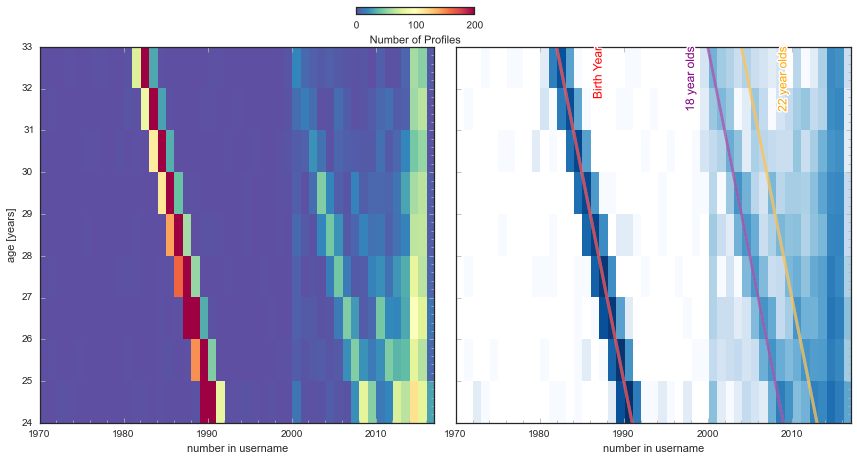

In [88]:
def setup_plot(**kwargs):
    setup(xlabel='number in username', ylabel='age [years]', **kwargs)
def add_line(x,y, label, offset=5, **kwargs):
    params = dict(label=label, lw=3, alpha=0.5, color='r')
    params.update(kwargs)
    outline(pylab.plot(x,y, **params))
    text(x[-1]+offset, y[-1], label, rotation=90, ha='center', va='top', fontsize=12, color=params['color'])
    
setup_plot(figsize=(12,6), subplt=(1,2,1))
den = density(fournum['username_number'], fournum['age'], 
              bins=[np.arange(1970,2018), np.arange(24,34), ],
              label='Number of Profiles', vmin=0, vmax=200,
              ynorm=False, cmap=pylab.cm.Spectral_r, colorbar=False)
icolorbar(den, loc=1, borderpad=-4)


setup_plot(subplt=(1,2,2), xr=[1970,2017], yticks=False)
den = density(fournum['username_number'], fournum['age'], logvrange=True,
              bins=[np.arange(1970,2018), np.arange(24,34), ],
              label='Number of Profiles', #vmin=0, vmax=1000,
              cmap=pylab.cm.Blues, colorbar=False)
age = np.arange(24,34)
add_line(2015-age, age, 'Birth Year')
add_line(2015+18-age, age, '18 year olds', color='purple', offset=-2)
add_line(2015+22-age, age, '22 year olds', color='orange')
pylab.tight_layout()

The two age dependent populations can be seen here.  There is a second population that can be seen here at 22 years old.  Going back to the previous 2 digit plots, the trend can be seen as well.  

# Classification

* Lets classify the 2-digit numbers to see if we can use it to classify their age. This is going to be a very simplistic model since we are predicting a age from a single feature of the dataset.  
* The above range sampling can be generalized to a random forest.
* 


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import cross_validation

In [71]:
rcf = RandomForestClassifier(
        random_state=0,
#         n_estimators=150,
#         min_samples_split=4,
#         min_samples_leaf=2
    )
scores = cross_validation.cross_val_score(rcf,
    num['username_number'].reshape(-1, 1),
    num["age"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

43.2


While 43% correct seems pretty bad, from the earlier visualizations the signal is only coming from two main populations wich contain 23% + 33% of the entire 2 digit sample. There is signal coming from the 08-15 range, however this is well mixed with the year of creation limiting its utility  This means this classifier is actually correct ~77% of the time when there is enough data to estimate the age.

What this dataset really needs is more features extracted from either the questions or profile text to really estimate the age well.

In [78]:
predicted = cross_validation.cross_val_predict(rfc, num['username_number'].reshape(-1, 1), num["age"], cv=10)

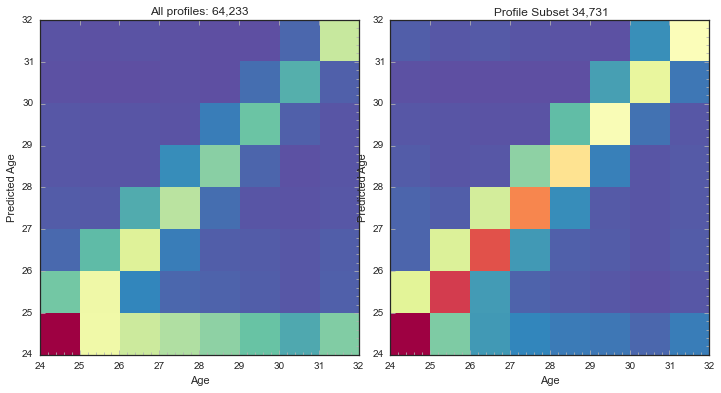

In [79]:
setup(figsize=(12,6), subplt=(1,2,1), 
      title='All profiles: {:,d}'.format(len(num)),
      xlabel='Age', ylabel='Predicted Age')
den = density(num["age"], predicted,
              bins=(np.arange(24,33),np.arange(24,33)),
              colorbar=False, cmap=pylab.cm.Spectral_r)


isgood = np.where( ( (num['username_number'] > 22) & (num['username_number'] < 34) ) |
                   ( (num['username_number'] > 82) & (num['username_number'] < 91) ) )[0]
setup(subplt=(1,2,2), 
      title='Profile Subset {:,d}'.format(len(isgood)),
      xlabel='Age', ylabel='Predicted Age')
den = density(num.iloc[isgood]['age'], predicted[isgood],
              bins=(np.arange(24,33),np.arange(24,33)),
              colorbar=False, cmap=pylab.cm.Spectral_r)


The random forest classifier is underestimating many of the ages as 24 year olds (bottom row of pixels).


In [69]:
scores = cross_validation.cross_val_score(
    GradientBoostingClassifier(
#         n_estimators=100, 
#         learning_rate=1.0, 
#         max_depth=1, 
        random_state=0
    ),
    num['username_number'].reshape(-1, 1),
    num["age"],
    cv=3
)
print('{:0.1f}'.format(100*scores.mean()))

43.4


Gradient Boosting Classifier does not preform much better.